<a href="https://colab.research.google.com/github/Roopesh-DMahanthi/Cats-vs-Dogs--Img-Classification/blob/master/CatsvsDogs_Image_Classification_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
print(tf.__version__)

2.2.0-rc3


In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-04-27 07:02:34--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.35.76.84, 2600:1407:a800:18d::e59, 2600:1407:a800:1a0::e59, ...
Connecting to download.microsoft.com (download.microsoft.com)|23.35.76.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  47.9MB/s    in 9.9s    

2020-04-27 07:02:44 (79.5 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [0]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [4]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [5]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

--2020-04-27 07:03:04--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   117MB/s    in 0.7s    

2020-04-27 07:03:05 (117 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

model = InceptionV3(input_shape=(150,150,3),include_top=False,weights=None)
model.load_weights(local_weights_file)

for layer in model.layers:
  layer.trainable=False

model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
last_layer=model.get_layer('mixed8')
print("Last-Layer Output Shape - ",last_layer.output_shape)
last_out=last_layer.output
last_out

Last-Layer Output Shape -  (None, 3, 3, 1280)


<tf.Tensor 'mixed8/Identity:0' shape=(None, 3, 3, 1280) dtype=float32>

In [0]:
class myCB(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% Accuracy.... Model Successfully Trained")
      self.model.stop_training=False
    
cb=myCB()

In [10]:
lay=layers.GlobalAveragePooling2D()(last_out)
lay=layers.Dense(1024,activation='relu')(lay)
lay=layers.Dropout(0.3)(lay)
lay=layers.Dense(1,activation='sigmoid')(lay)

model=Model(model.input,lay)
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
train_dir = '/tmp/cats-v-dogs/training'
test_dir = '/tmp/cats-v-dogs/testing'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 90,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   shear_range = 0.3,
                                   zoom_range = 0.4,
                                   horizontal_flip = True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255)

train_gen = train_datagen.flow_from_directory(train_dir,batch_size=30,class_mode='binary',target_size=(150,150))
test_gen = test_datagen.flow_from_directory(test_dir,batch_size=30,class_mode='binary',target_size=(150,150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [12]:
history = model.fit(train_gen,validation_data=test_gen,validation_steps=100,steps_per_epoch=200,epochs=15,callbacks=[cb])

Epoch 1/15
200/200 [==============================] - 371s 2s/step - loss: 0.4714 - accuracy: 0.8038 - val_loss: 0.3212 - val_accuracy: 0.8899
Epoch 2/15
200/200 [==============================] - 368s 2s/step - loss: 0.3396 - accuracy: 0.8480 - val_loss: 0.0918 - val_accuracy: 0.9584
Epoch 3/15
 38/200 [====>.........................] - ETA: 3:22 - loss: 0.3126 - accuracy: 0.8474

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

200/200 [==============================] - 371s 2s/step - loss: 0.3013 - accuracy: 0.8660 - val_loss: 0.1383 - val_accuracy: 0.9430
Epoch 4/15
200/200 [==============================] - 369s 2s/step - loss: 0.2931 - accuracy: 0.8716 - val_loss: 0.0828 - val_accuracy: 0.9661
Epoch 5/15
200/200 [==============================] - 376s 2s/step - loss: 0.2808 - accuracy: 0.8760 - val_loss: 0.0773 - val_accuracy: 0.9659
Epoch 6/15
200/200 [==============================] - 375s 2s/step - loss: 0.2648 - accuracy: 0.8855 - val_loss: 0.0833 - val_accuracy: 0.9658
Epoch 7/15
200/200 [==============================] - 373s 2s/step - loss: 0.2690 - accuracy: 0.8810 - val_loss: 0.0830 - val_accuracy: 0.9648
Epoch 8/15
200/200 [==============================] - 374s 2s/step - loss: 0.2587 - accuracy: 0.8911 - val_loss: 0.1007 - val_accuracy: 0.9601
Epoch 9/15
200/200 [==============================] - 371s 2s/step - loss: 0.2568 - accuracy: 0.8873 - val_loss: 0.0676 - val_accuracy: 0.9691
Epoch 10/1

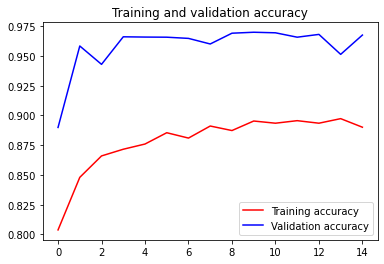

<Figure size 432x288 with 0 Axes>

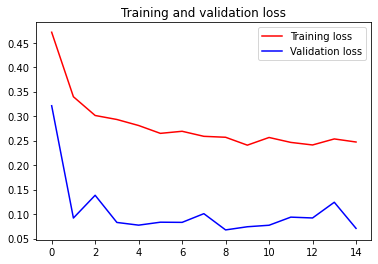

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [14]:
model.save('cats-vs-dogs_model.h5')
from google.colab import files
files.download('cats-vs-dogs_model.h5') 

KeyboardInterrupt: ignored

In [30]:
import os
import numpy as np
from keras.preprocessing import image
fi=os.listdir('/tmp/cats-v-dogs/testing/cats')
for i in fi[:15]:
  nd='/tmp/cats-v-dogs/testing/cats/'+i
  img = image.load_img(nd, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(i + " is a dog")
  else:
    print(i + " is a cat")

[1.]
6046.jpg is a dog
[1.]
7439.jpg is a dog
[1.]
2530.jpg is a dog
[1.]
4813.jpg is a dog
[1.]
11485.jpg is a dog
[1.]
10618.jpg is a dog
[1.]
4036.jpg is a dog
[1.]
6304.jpg is a dog
[1.]
9503.jpg is a dog
[1.]
11631.jpg is a dog
[1.]
4591.jpg is a dog
[1.]
1334.jpg is a dog
[1.]
8286.jpg is a dog
[1.]
1559.jpg is a dog
[1.]
3295.jpg is a dog


In [28]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  print("name:",fn)
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving catpic.jpg to catpic.jpg
name: catpic.jpg
[1.]
catpic.jpg is a dog


In [27]:
import requests
pic_url=input("Enter URL :")
with open('pic.jpg', 'wb') as handle:
        response = requests.get(pic_url, stream=True)

        if not response.ok:
            print(response)

        for block in response.iter_content(1024):
            if not block:
                break
            handle.write(block)

from keras.preprocessing import image
img = image.load_img('/content/pic.jpg', target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])
if classes[0]>0.5:
    print("Pic is a dog")
else:
    print("Pic is a cat")

Enter URL :https://static.toiimg.com/photo/msid-67586673/67586673.jpg?3918697
[1.]
Pic is a dog
